In [5]:
import cv2 

img = cv2.imread('../../flowers/astilbe/10091895024_a2ea04cda6_c.jpg')
""" img = cv2.imread('/home/angel/Desktop/IA/sportimages/basket/basket_0004.jpg') """

print(img.shape[0], img.shape[1], img.shape[2], len(img.shape))

256 256 3 3


# Convolutional Neural Networks

# Importar Librerías

In [6]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from skimage.transform import resize

In [7]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D
)
from keras.layers import LeakyReLU

# Cargar set de Imágenes

In [8]:
dirname = os.path.join(os.getcwd(),'../../sportimages/')
""" dirname = os.path.join(os.getcwd(),'/home/likcos/DataSets/sportimages/sportimages') """
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)



for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            if(len(image.shape)==3):
                images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  c:\Users\jorge\Desktop\Tec\9no Sem\Tecnm-ITM_IA\CNN\../../sportimages/\
c:\Users\jorge\Desktop\Tec\9no Sem\Tecnm-ITM_IA\CNN\../../sportimages/\americano 1
c:\Users\jorge\Desktop\Tec\9no Sem\Tecnm-ITM_IA\CNN\../../sportimages/\basket 9348
c:\Users\jorge\Desktop\Tec\9no Sem\Tecnm-ITM_IA\CNN\../../sportimages/\futbol 8823
Directorios leidos: 3
Imagenes en cada directorio [9349, 8823, 7616]
suma Total de imagenes en subdirs: 25788


# Creamos las etiquetas

In [9]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))


Cantidad etiquetas creadas:  25788


In [43]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 americano
1 basket
2 futbol


In [44]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy



# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  3
Output classes :  [0 1 2]


# Creamos Sets de Entrenamiento y Test

In [67]:
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (25788, 21, 28, 3)
Shape of y: (25788,)


In [45]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (20630, 21, 28, 3) (20630,)
Testing data shape :  (5158, 21, 28, 3) (5158,)


Text(0.5, 1.0, 'Ground Truth : 2')

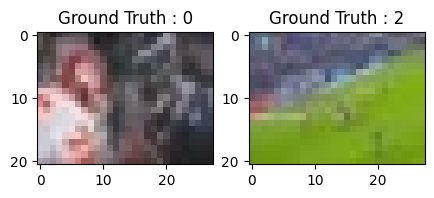

In [46]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

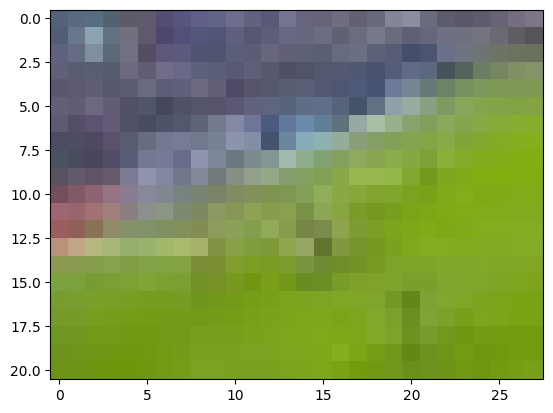

In [47]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X/255.
test_X = test_X/255.
plt.imshow(test_X[0,:,:])

## Hacemos el One-hot Encoding para la red

In [48]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 0
After conversion to one-hot: [1. 0. 0.]


# Creamos el Set de Entrenamiento y Validación

In [49]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [50]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(16504, 21, 28, 3) (4126, 21, 28, 3) (16504, 3) (4126, 3)


# Creamos el modelo de CNN

In [51]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 20 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [52]:
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))

sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5))
sport_model.add(Dense(nClasses, activation='softmax'))

In [53]:
sport_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 21, 28, 32)        896       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 21, 28, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 11, 14, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 4928)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                157728    
                                                      

In [54]:
sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

# Entrenamos el modelo: Aprende a clasificar imágenes

In [55]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20
258/258 [==============================] - 1s 5ms/step - loss: 1.0734 - accuracy: 0.4144 - val_loss: 0.9891 - val_accuracy: 0.6949
Epoch 2/20
258/258 [==============================] - 1s 4ms/step - loss: 1.0002 - accuracy: 0.5222 - val_loss: 0.9136 - val_accuracy: 0.7831
Epoch 3/20
258/258 [==============================] - 1s 4ms/step - loss: 0.9358 - accuracy: 0.5742 - val_loss: 0.8359 - val_accuracy: 0.7867
Epoch 4/20
258/258 [==============================] - 1s 4ms/step - loss: 0.8738 - accuracy: 0.6190 - val_loss: 0.7640 - val_accuracy: 0.8030
Epoch 5/20
258/258 [==============================] - 1s 4ms/step - loss: 0.8192 - accuracy: 0.6488 - val_loss: 0.7031 - val_accuracy: 0.8141
Epoch 6/20
258/258 [==============================] - 1s 4ms/step - loss: 0.7777 - accuracy: 0.6761 - val_loss: 0.6563 - val_accuracy: 0.8289
Epoch 7/20
258/258 [==============================] - 1s 4ms/step - loss: 0.7415 - accuracy: 0.6985 - val_loss: 0.6200 - val_accuracy: 0.8376
Epoch 

In [56]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
""" sport_model.save("/home/likcos/setDocto/celulas.h5py") """
sport_model.save("./sportimages.h5py")

INFO:tensorflow:Assets written to: ./sportimages.h5py\assets


INFO:tensorflow:Assets written to: ./sportimages.h5py\assets


# Evaluamos la red

In [57]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

162/162 [==============================] - 0s 938us/step - loss: 0.3857 - accuracy: 0.8879


In [58]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.38569140434265137
Test accuracy: 0.8879410624504089


In [59]:
sport_train.history

{'loss': [1.073408603668213,
  1.0001873970031738,
  0.9358088374137878,
  0.8737984895706177,
  0.8191844820976257,
  0.7777283787727356,
  0.741504430770874,
  0.707763671875,
  0.6802592873573303,
  0.6558358073234558,
  0.6344237327575684,
  0.6183330416679382,
  0.6013978719711304,
  0.5807584524154663,
  0.5681420564651489,
  0.5564980506896973,
  0.5375769138336182,
  0.5321025848388672,
  0.5199213624000549,
  0.5052791237831116],
 'accuracy': [0.4144449830055237,
  0.5221764445304871,
  0.5742244124412537,
  0.6190014481544495,
  0.6487517952919006,
  0.6761391162872314,
  0.6984973549842834,
  0.7207343578338623,
  0.7344886064529419,
  0.7451527118682861,
  0.7621182799339294,
  0.7732064723968506,
  0.7791444659233093,
  0.7930198907852173,
  0.8025327324867249,
  0.8026539087295532,
  0.8139845132827759,
  0.8184076547622681,
  0.8279204964637756,
  0.8273751735687256],
 'val_loss': [0.9890584349632263,
  0.913646399974823,
  0.8359172344207764,
  0.7640352845191956,
  0.7

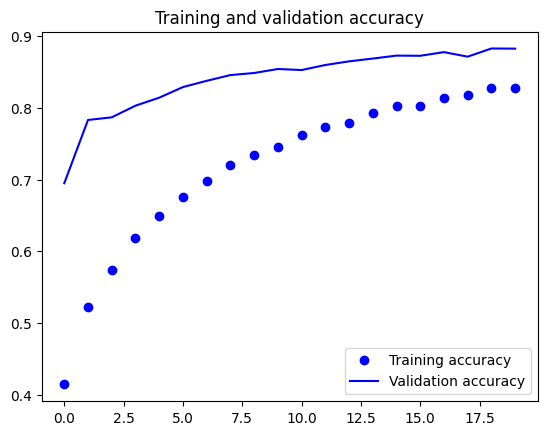

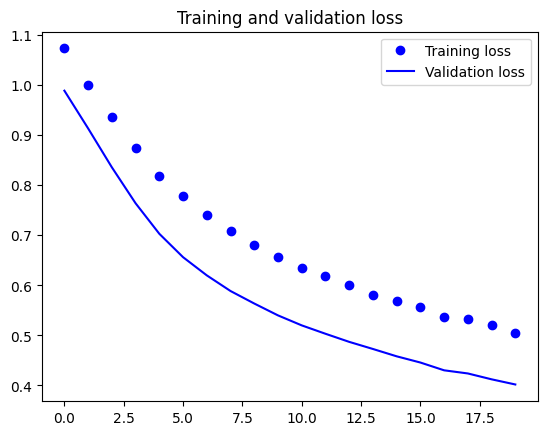

In [60]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [61]:
predicted_classes2 = sport_model.predict(test_X)

162/162 [==============================] - 0s 870us/step


In [62]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [63]:
predicted_classes.shape, test_Y.shape

((5158,), (5158,))

# Aprendamos de los errores: Qué mejorar

Found 4580 correct labels


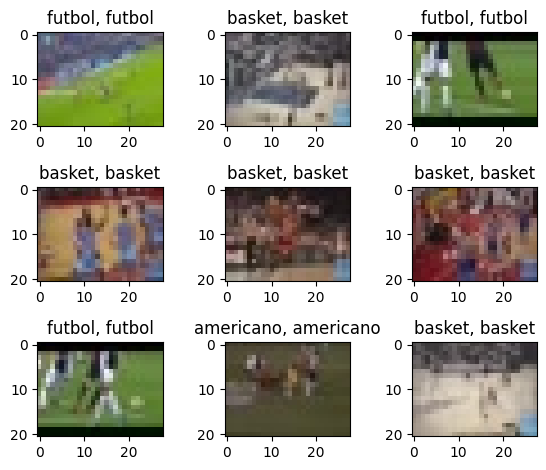

In [64]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 578 incorrect labels


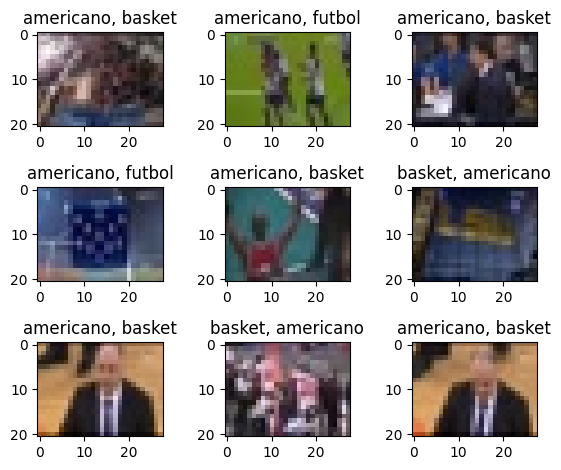

In [65]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [66]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.83      0.88      0.86      1879
     Class 1       0.88      0.90      0.89      1757
     Class 2       0.98      0.88      0.93      1522

    accuracy                           0.89      5158
   macro avg       0.90      0.89      0.89      5158
weighted avg       0.89      0.89      0.89      5158

